In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!kaggle datasets download -d abishekb12123/balanced-mo-106

100% 1.74G/1.74G [01:41<00:00, 23.3MB/s]
100% 1.74G/1.74G [01:41<00:00, 18.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/balanced-mo-106.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization,Dropout

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator
# #Image generator for training data
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)
# # Image generator for test_data
# test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# # Creating training set
# training_set = train_datagen.flow_from_directory('/content/MO_106/Train_directory',
#                                                  target_size = (64, 64),
#                                                  batch_size = 128,
#                                                  class_mode = 'binary')

Found 20440 images belonging to 2 classes.


In [ ]:
#Creating test set
# validation_set = test_datagen.flow_from_directory('/content/MO_106/Validation_directory',
#                                                  target_size = (64, 64),
#                                                  batch_size = 128,
#                                                  class_mode = 'binary')

Found 5110 images belonging to 2 classes.


In [ ]:
training_set = keras.utils.image_dataset_from_directory(
    directory = '/content/MO_106/Train_directory',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 128,
    image_size = (48,48)
)

Found 20440 files belonging to 2 classes.


In [ ]:
validation_set = keras.utils.image_dataset_from_directory(
    directory = '/content/MO_106/Validation_directory',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 128,
    image_size = (48,48)
)

Found 5110 files belonging to 2 classes.


In [ ]:
def process(image,label):
  image = tf.cast(image/255. , tf.float32)
  return image,label

training_set = training_set.map(process)
validation_set = validation_set.map(process)

In [ ]:
#CNN Model architecture
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])

In [ ]:
model.save('content/save_model.h5')

In [ ]:
#Saving model as json
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
# from keras.utils import plot_model
# plot_model(model, show_shapes = True, to_file='/content/MO_106/model.png')

In [ ]:
#Model fitting
history = model.fit(training_set,steps_per_epoch= len(training_set),validation_data = validation_set,
                    validation_steps = len(validation_set),
                    epochs = 50)
model.save_weights('/content/weights.h5')
import pickle
with open('/content/history', 'wb') as f:
        pickle.dump(history.history, f)


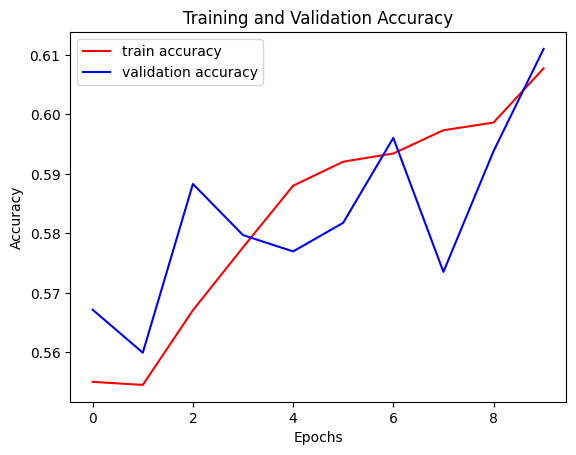

In [ ]:
# training and Validation accuracy plotting
import pickle
with open('/content/history','rb') as f:
  hist = pickle.load(f)

plt.plot(hist["accuracy"],label="train accuracy",color="red")
plt.plot(hist["val_accuracy"],label="validation accuracy",color="blue")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig("/content/drive/MyDrive/training_history.png")
plt.show()


In [ ]:
model.evaluate(validation_set)

46/46 [==============================] - 40s 864ms/step - loss: 1.1509 - accuracy: 0.6363


[1.1509151458740234, 0.6362543106079102]

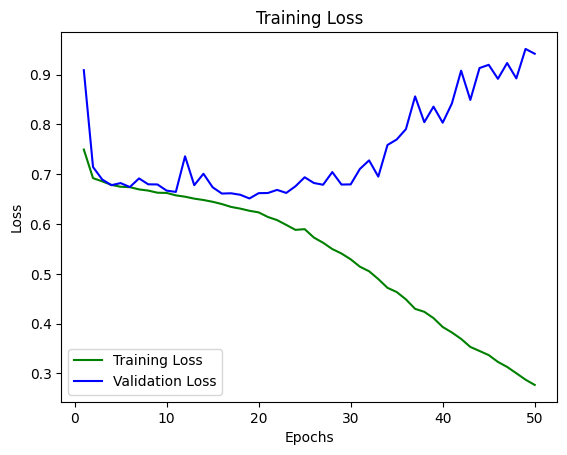

In [ ]:
# loss graph
with open('/content/history','rb') as f:
  hist = pickle.load(f)

train_loss = hist['loss']
val_loss = hist['val_loss']

# Plot the loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Model loading with weights
model.load_weights('/weights.h5')

In [ ]:
print(training_set.class_indices)
print(training_set.classes)

{'Edible': 0, 'Inedible': 1}
[0 0 0 ... 1 1 1]


In [ ]:
#Confusion Matrix for training data
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score, f1_score
import seaborn as sns

# Get the true labels from the iterator
y_true = training_set.classes

# Generate predictions using your CNN model
y_pred = model.predict(training_set)

# Convert probabilities to binary predictions based on a threshold
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
# accuracy = accuracy_score(y_true, y_pred_binary)
# print("Accuracy:", accuracy)

# # Calculate precision
# precision = precision_score(y_true, y_pred_binary)
# print("Precision:", precision)

# # Calculate recall
# recall = recall_score(y_true, y_pred_binary)
# print("Recall:", recall)

# # Calculate F1 score
# f1 = f1_score(y_true, y_pred_binary)
# print("F1 Score:", f1)

class_names = list(training_set.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from skimage.transform import resize
from skimage.io import imread
DATASET_PATH = '/content/drive/MyDrive/mushroom_world/'
mushroom_info = pd.read_json(DATASET_PATH + 'mushroom_info_old.json')

In [ ]:
import os
img_dict ={}
label = {}
for i in range(len(mushroom_info)):
  img_dict[i] = imread(os.path.join('/content/drive/MyDrive/mushroom_world/',mushroom_info.loc[i,'file_path']))


In [ ]:
for i in range(len(img_dict)):
  img_dict[i] = resize(img_dict[i],(64,64,3))

In [ ]:
labels = mushroom_info.edibility.isin(("edible", "edible and good", "edible and excellent"))
X = []
y = []

for i in range(len(labels)):

        y.append(labels[i])
        X.append(img_dict[i])

target_arr = []
X = np.stack(X)
y = pd.Series(y)
for i in range(len(y)):
  if(y[i] == True ):
    target_arr.append(0)
  else:
    target_arr.append(1)

target = np.array(target_arr)
print(X.shape)
print(y.shape)
print(target)
X = X/255.0

(536, 64, 64, 3)
(536,)
[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 

17/17 [==============================] - 0s 10ms/step
[[0.9969478 ]
 [0.99687093]
 [0.99677926]
 [0.99696404]
 [0.99709666]
 [0.9972746 ]
 [0.9971655 ]
 [0.9970872 ]
 [0.99694794]
 [0.9973671 ]
 [0.9973514 ]
 [0.9973247 ]
 [0.9972481 ]
 [0.9975036 ]
 [0.9969909 ]
 [0.9973242 ]
 [0.99706775]
 [0.9974474 ]
 [0.99738556]
 [0.9970797 ]
 [0.99711007]
 [0.99696594]
 [0.99732745]
 [0.9972874 ]
 [0.99703985]
 [0.99702376]
 [0.99706995]
 [0.9973145 ]
 [0.99718815]
 [0.99722844]
 [0.9970878 ]
 [0.9971355 ]
 [0.9972602 ]
 [0.997145  ]
 [0.99732107]
 [0.99687284]
 [0.99718237]
 [0.99719703]
 [0.9972452 ]
 [0.997323  ]
 [0.997152  ]
 [0.99727184]
 [0.99717027]
 [0.9972475 ]
 [0.99725085]
 [0.99698997]
 [0.9971942 ]
 [0.9973718 ]
 [0.99721307]
 [0.99710435]
 [0.99734527]
 [0.9973258 ]
 [0.99733365]
 [0.9973003 ]
 [0.9971757 ]
 [0.9971551 ]
 [0.99726295]
 [0.997322  ]
 [0.99729025]
 [0.99715686]
 [0.99739146]
 [0.9972511 ]
 [0.9971705 ]
 [0.9969318 ]
 [0.99744654]
 [0.9972855 ]
 [0.99738294]
 [0.9973

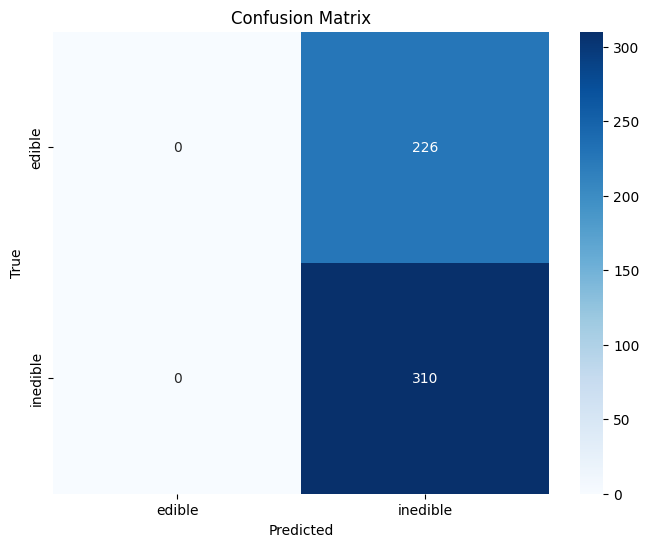

In [ ]:
#Confusion Matrix for testing data
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score, recall_score, f1_score
import seaborn as sns

y_predictions = model.predict(X)
print(y_predictions)
threshold = 0.5
y_pred_binary = np.where(y_predictions > threshold, 1, 0)
y_true = target
# predicted_labels = np.argmax(y_pred_binary, axis=1)
cm = confusion_matrix(y_true, y_pred_binary)


#Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred_binary)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred_binary)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_binary)
print("F1 Score:", f1)

#To Create the heatmap
class_names = {'edible': 0, 'inedible': 1}
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Enter a number20


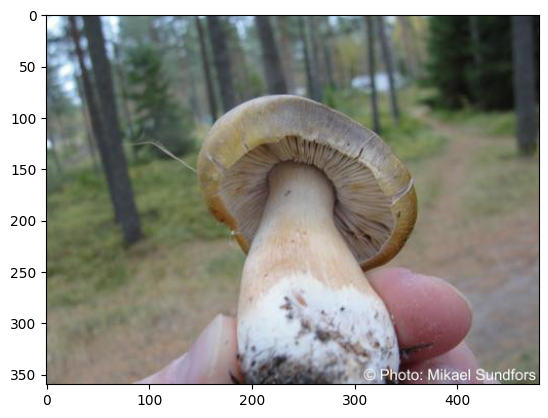

1/1 [==============================] - 0s 19ms/step
[[0.62767285]]
name:Tricholoma sejunctum False Edible Trich
Actual edibility:inedible
Inedible


In [ ]:
i = input("Enter a number")
plt.imshow(img_dict[int(i)])
plt.show()
img = img_dict[int(i)]
img_resize=resize(img,(64,64,3))
img_reshape = img_resize.reshape(1,64,64,3)
probability = model.predict(img_reshape)
print(probability)
print('name:'+ mushroom_info.loc[int(i),"name_latin"] +" "+ mushroom_info.loc[int(i),"name_eng"] )
print('Actual edibility:'+ mushroom_info.loc[int(i),"edibility"])

if(probability > 0.4):
  print("Inedible")
else:
  print("Edible")